<a href="https://colab.research.google.com/github/adasegroup/ML2020_seminars/blob/master/seminar13/deep_learning_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seminar 13: Deep Learning
At the last seminar, we trained MLP in PyTorch for classification of MINIST digits.

![](https://github.com/adasegroup/ML2020_seminars/raw/master/seminar12/img/pic1.png)

```python
net = torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_dim_size, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_dim_size, number_of_classes, bias=True)
)
```

At this seminar, we will try to solve a similar problem of 10-class classification of small pictures for another dataset --- CIFAR-10.
![](https://github.com/adasegroup/ML2020_seminars/raw/master/seminar13/img/cifar.png)

In [ ]:
!wget https://raw.githubusercontent.com/adasegroup/ML2020_seminars/master/seminar13/utils.py -P local_modules -nc

import sys
sys.path.append('local_modules')

In [ ]:
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from tqdm import trange

from utils import get_accuracy, Monitor, set_random_seeds

## 1. Intro
First, let's recall that for training we need to
* prepare the data
* choose neural network architecture,
* choose the loss function,
* choose an optimizer.

### PyTorch Dataset and DataLoader
To download the data, we used the baby version of MNIST from scikit-learn.
Today we will use the adult version from `torchvision.datasets`.

We specify the directory in which the dataset will be located, indicate that we want to download it, and that we want to select the training subset.

In [ ]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

In [ ]:
mnist_train = torchvision.datasets.MNIST('./mnist', download=True, train=True)

When the data is downladed, we can iterate over `mnist_train`. It consists of 60,000 28x28 images.

In [ ]:
for x, y in mnist_train:
    print(x, y)
    break
    
print(len(mnist_train))
mnist_train[0][0]

<PIL.Image.Image image mode=L size=28x28 at 0x7FBEF8162978> tensor(5)
60000


To convert input images from `PIL.Image` to` torch.Tensor`, we use the `transform` parameter.

In [ ]:
mnist_train = torchvision.datasets.MNIST('./mnist', train=True, transform=torchvision.transforms.ToTensor())
mnist_train[0][0].__class__

torch.Tensor

If we want to load input-target pairs not one at a time but in batches, i.e. several at a time, to process them in parallel, we can use `torch.utils.data.DataLoader`.
We pass it a dataset, specify `batch_size`, and we can also indicate that we want to load the data in multiple threads using `num_workers` parameter.

In [ ]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=64, num_workers=4)

for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([64, 1, 28, 28]) torch.Size([64])


### PyTorch Module
We will start with the same architecture that we had at last seminar:
```python
torch.nn.Sequential(
    torch.nn.Linear(input_size, hidden_dim_size, bias=True),
    torch.nn.ReLU(),
    torch.nn.Linear(hidden_dim_size, number_of_classes, bias=True)
)
```

The first linear block of this a model inputs a one-dimensional tensor of shape `[input_size]` (or a batch of one-dimensional tensors of shape `[batch_size, input_size]`), while our input images have shape `[28, 28]`, so we need to reshape the input images before feeding into the model.
Let's encapsulate this operation inside the model.

For this, we will make the class `MLPBased` which inherits from` torch.nn.Module`.
We pass to the constructor the size of the input image from which we calculate the `input_size` of the first linear block,
we save the sequence of all blocks in the `mlp` attribute,
and in the `forward` method, which is used when we calculate the output of the model `model(input)`,
reshape the input and pass it to `mlp`.

In [ ]:
class MLPBased(torch.nn.Module):
    def __init__(self, input_image_size, hidden_dim_size, number_of_classes):
        super().__init__()
        
        input_size = input_image_size[0] * input_image_size[1]
        
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_dim_size),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim_size, number_of_classes)
        )
        
    def forward(self, x):
        # x is of shape [batch_size, 1, height, width]
        x = x.reshape(x.shape[0], -1)  # [batch_size, height * width]
        return self.mlp(x)

### Loss
Throughout the whole seminar we will use CrossEntropyLoss, same as in the previous seminar.

In [ ]:
loss_function = torch.nn.CrossEntropyLoss()

### Optimizer
We will start with Gradient Descent with momentum as our baseline.
```python
torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
```

#### Gradient descent vs Stochastic gradient descent vs Mini-batch gradient descent
At the last seminar, we calculated the outputs of the neural network in parallel for the entire dataset, averaged the loss over the entire dataset and updated the network parameters w.r.t this average.
This variant of optimization is called Gradient Descent or Batch Gradient Descent.
```python
output = model(all_inputs)
loss = loss_f(output, all_targets)
optimizer.zero_grad()
loss.backward()
optimizer.step()
```

The real-world training datasets are rather large, so parallel computation on the whole dataset becomes inefficient in memory.
Therefore, there is another well-established variant called Stochastic gradient descent.
In this variant, we select samples in random order one at a time, and for each separately calculate the model output, the loss and do an update
```python
for input, target in data:
    output = model(input)
    loss = loss_f(output, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
```

This variant is not optimal in terms of time, and in practice we use something in between these two options, the so-called Mini-batch gradient descent.
Here, we take the samples not one at a time, but in batches of multiple samples
```python
for input_batch, target_batch in data:
    output = model(input_batch)
    loss = loss_f(output, target_batch)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
```
We will use this option.
The optimal batch size is chosen experimentally; good values for today's seminar are in range 64-512.

### Train procedure

In [ ]:
# we choose the device that we will work on --- GPU or CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

def train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=1, plot_each=1):
    # send the model to that device
    model = model.to(device)
    # initialize some visualization code that you don't need to care about
    monitor = Monitor()
    # one full cycle on train data is called epoch
    for epoch in trange(epochs_n):
        # switch the model to the train mode
        # later on we will have some blocks that behave differently in train and test mode
        model.train()
        for model_input, target in train_loader:
            # send data to device
            model_input = model_input.to(device)
            target = target.to(device)
            # calculate outputs and loss
            model_output = model(model_input)
            loss = loss_function(model_output, target)
            # update model weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # do some visualization
            monitor.add_loss_value(loss.item())
        
        # evaluate our model
        model.eval()
        train_accuracy = get_accuracy(model, train_loader, device)
        val_accuracy = get_accuracy(model, val_loader, device)
        monitor.add_train_accuracy_value(train_accuracy)
        monitor.add_val_accuracy_value(val_accuracy)
        
        if epoch % plot_each == 0:
            monitor.show()

### Exercise 1
Now, let's put everything together and try to train an `MLPBased` classifier for CIFAR-10.

First, make sure that everything works for MNIST. Don't train for too long, just for a couple of epochs.
Then use [`torchvision.datasets.CIFAR10`](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar).

#### MNIST

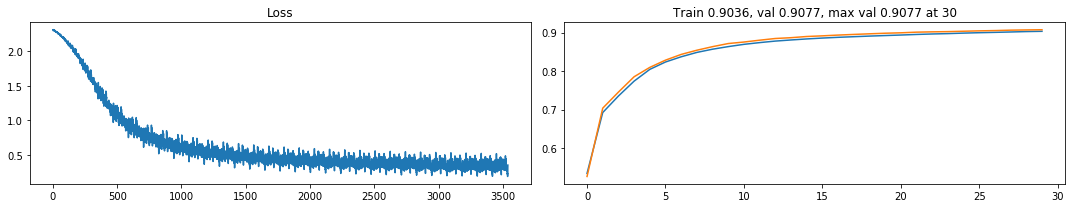

100%|██████████| 30/30 [01:15<00:00,  2.51s/it]


In [ ]:
set_random_seeds(device=device)

# data
mnist_train = torchvision.datasets.MNIST('./mnist', train=True, download=True,
                                         transform=torchvision.transforms.ToTensor())
mnist_val = torchvision.datasets.MNIST('./mnist', train=False, download=True,
                                       transform=torchvision.transforms.ToTensor())

batch_size = 512
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, num_workers=4)
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size, num_workers=4)

# model
model = MLPBased([28, 28], 100, 10)

# optimization
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

# train
train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=30)

#### CIFAR

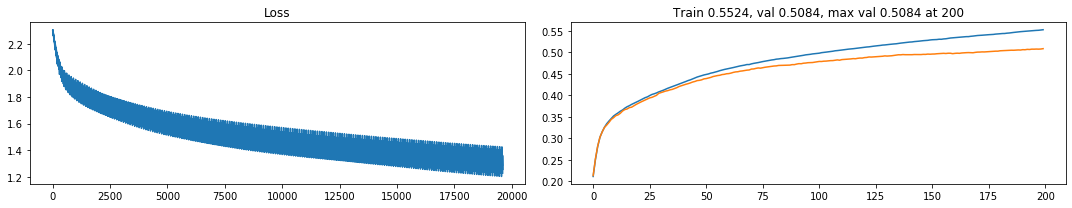

100%|██████████| 200/200 [09:35<00:00,  2.85s/it]


In [ ]:
set_random_seeds(device=device)

# data
cifar_train = torchvision.datasets.CIFAR10('./cifar', train=True, download=True,
                                           transform=torchvision.transforms.ToTensor())
cifar_val = torchvision.datasets.CIFAR10('./cifar', train=False, download=True,
                                         transform=torchvision.transforms.ToTensor())

batch_size = 512
train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size, num_workers=4)
val_loader = torch.utils.data.DataLoader(cifar_val, batch_size=batch_size, num_workers=4)

# model
class MLPBased(torch.nn.Module):
    def __init__(self, input_image_size, hidden_dim_size, number_of_classes):
        super().__init__()
        input_size = np.prod(input_image_size)  # <---
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_dim_size, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim_size, number_of_classes, bias=True)
        )
        
    def forward(self, x):
        # x is of shape [batch_size, channels_n, height, width]
        x = x.reshape(x.shape[0], -1)
        return self.mlp(x)
model = MLPBased([3, 32, 32], 100, 10)

# optimization
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

# train
train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=200)

We see two things.
First, training neural networks on real datasets takes quite a lot of time (although this is still very fast).
Second, while on MNIST our MLP achieves 90% accuracy with almost no tuning, on CIFAR the accuracy is significantly lower (although the model was not trained well).

In this seminar we will try different deep learning techniques to get better performance at CIFAR classification.
We'll look at these techniques on MNIST and then you'll try them for CIFAR.

## 2. Develop on subset
Firstly, we'll select small subsets from the whole training and validation datasets to be able to quickly try different things.

For this we'll use `torch.utils.data.Subset` to which we pass the source dataset and a set of indices that select a subset.

In [ ]:
subset_size = 64
mnist_train_subset = torch.utils.data.Subset(mnist_train, torch.arange(subset_size))
mnist_val_subset = torch.utils.data.Subset(mnist_val, torch.arange(subset_size))

Let's check that our subsets are not too small and still represent the original datasets.

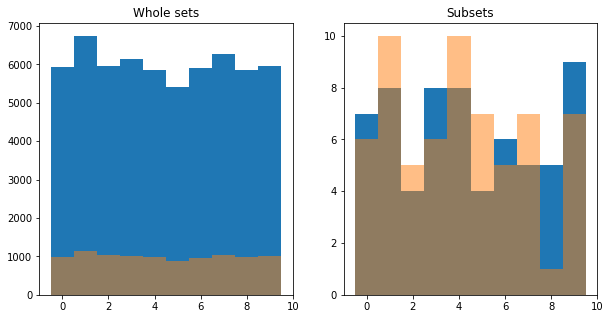

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].set_title('Whole sets')
ax[0].hist([target for _, target in mnist_train], bins=10, range=(-.5, 9.5));
ax[0].hist([target for _, target in mnist_val], bins=10, range=(-.5, 9.5), alpha=.5);
ax[1].set_title('Subsets')
ax[1].hist([target for _, target in mnist_train_subset], bins=10, range=(-.5, 9.5));
ax[1].hist([target for _, target in mnist_val_subset], bins=10, range=(-.5, 9.5), alpha=.5);

Actually, these subsets do not represent the whole datasets, but it's even better for educational purpose.

Let's see how the model performs on these subsets.

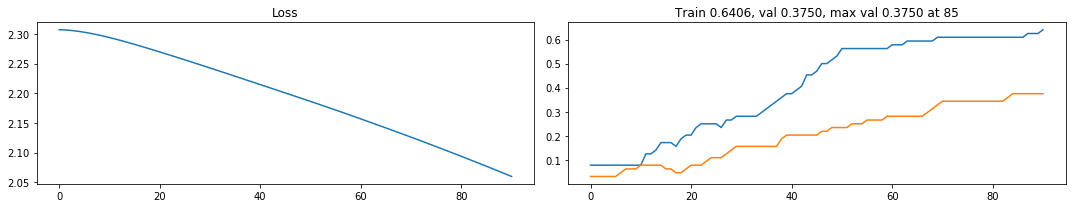

100%|██████████| 100/100 [00:35<00:00,  2.96it/s]


In [ ]:
set_random_seeds(device=device)

batch_size = 64
train_loader = torch.utils.data.DataLoader(mnist_train_subset, batch_size=batch_size, num_workers=4)
val_loader = torch.utils.data.DataLoader(mnist_val_subset, batch_size=batch_size, num_workers=4)

model = MLPBased([28, 28], 100, 10)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=100, plot_each=10)

First, based on the loss curve we see that the lerning rate is too small --- let's make it larger.

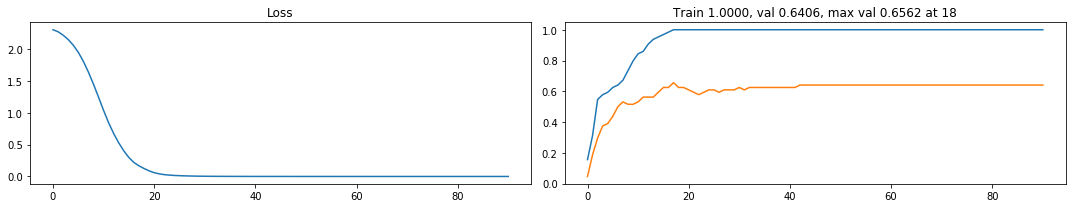

100%|██████████| 100/100 [00:34<00:00,  2.95it/s]


In [ ]:
set_random_seeds(device=device)

model = MLPBased([28, 28], 100, 10)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)

train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=100, plot_each=10)

Во-вторых мы видим что модель достигает идеальной точности на обучающей выборке и, ожидаемо, перестает учиться. При этом точность на валидационной выборке низкая. Это называется переобучением. Давайте попробуем data augmentation.

Second, we see that the model achieves perfect accuracy on the training set and, as expected, stops learning.
However, the accuracy on the validation set is low.
This is called overfitting: the model is not general and performs poorly on the data that it trained on.  
Let's try data augmentation to beat that.

## 3. Augment your data
Let's take a look at threes in our training and validation data.

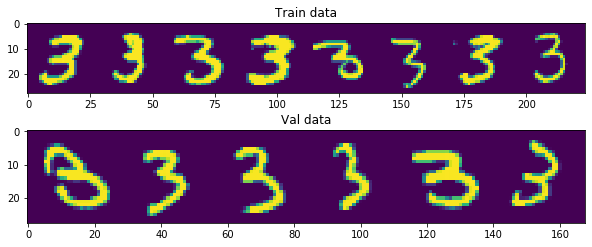

In [ ]:
f, ax = plt.subplots(2, figsize=(10, 4))
ax[0].set_title('Train data')
ax[1].set_title('Val data')
for x, y in train_loader:
    x = x[:, 0][y == 3]
    ax[0].imshow(np.hstack(x))
for x, y in val_loader:
    x = x[:, 0][y == 3]
    ax[1].imshow(np.hstack(x))

They are different, but not that different.
For example, the first three on the left from train and the second on the right from validation look pretty similar, as if one is a sheared version of the other.
Following this observation, we will artificially expand the training data by applying random transformations to the samples.
This is called data augmentation.

We will use random rotations in the range of [-30.30] degrees, random shears by [-30.30] degrees, and random scaling by the factor 0.7 to 1.05.

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(degrees=30, shear=30, scale=(.7, 1.05)),
    torchvision.transforms.ToTensor()])


mnist_train_subset = torch.utils.data.Subset(
    torchvision.datasets.MNIST('./mnist', train=True, download=True, transform=transform), torch.arange(subset_size))

train_loader = torch.utils.data.DataLoader(mnist_train_subset, batch_size=batch_size, num_workers=4)

And now from 64 train samples we get infinitely many different ones.

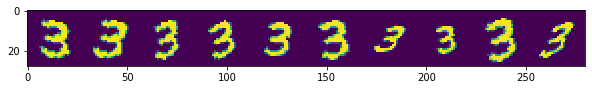

In [ ]:
augmentations = []
for _ in range(10):
    x, _ = mnist_train_subset[7]
    augmentations.append(x[0])

plt.figure(figsize=(10, 10))
plt.imshow(np.hstack(augmentations))

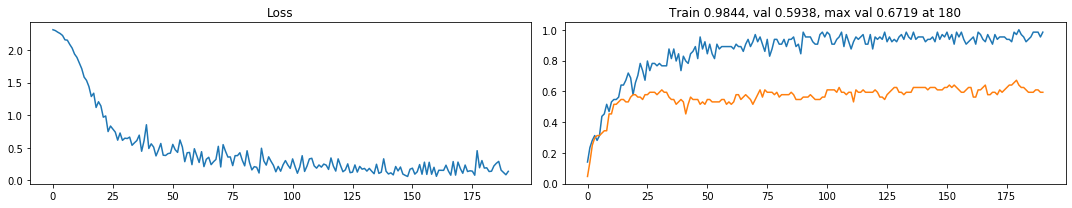

100%|██████████| 200/200 [01:14<00:00,  2.86it/s]


In [ ]:
set_random_seeds(device=device)

model = MLPBased([28, 28], 100, 10)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)

train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=200, plot_each=10)

Now our model doesn't that easy trains to the perfect train accuracy.
However, it didn't help with overfitting,
so let's try a different architecture.

## 4. Use CNNs
Convolutional neural networks, or simply CNNs, are composed, at their base, of two types of blocks --- convolutional layers and pooling layers.

Convolutions in CNNs look for some patterns in the input image or feature map.
For example, if I want to find this zero in the image

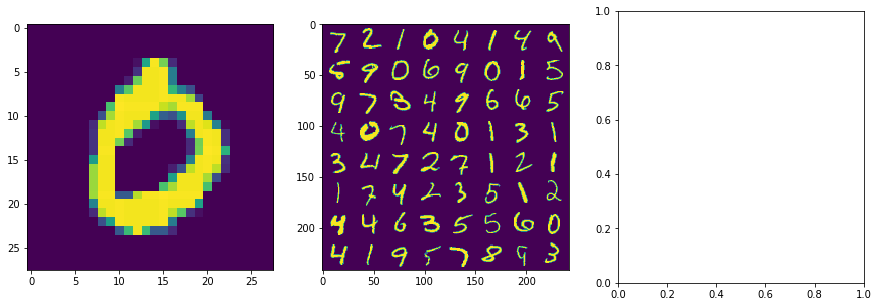

In [ ]:
for x, _ in val_loader:
    imgrid = torchvision.utils.make_grid(x, nrow=8)
    break

imgrid = imgrid[:1]
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[1].imshow(imgrid.numpy()[0])

zero = mnist_val_subset[3][0]
ax[0].imshow(zero.numpy()[0])

I use a convolution with this zero as the kernel.

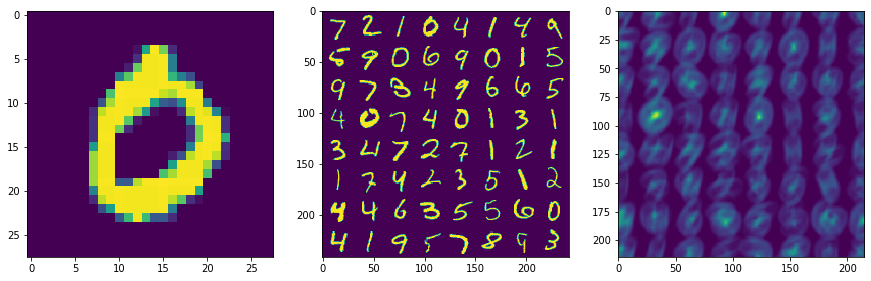

In [ ]:
conv = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=28, bias=0)
conv.weight.data[:] = zero

conv_out = conv(imgrid[None])

ax[2].imshow(conv_out.data.numpy()[0, 0])
fig

The convolution slides its kernel, this zero, over the image and outputs the correlation of its kernel with a part of the image.

![](https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif)

Pooling layers that follow convolutional layers simply reduce the dimensions of the output,
which lowers the number of computations in the following layers and forces learning more representative kernels.

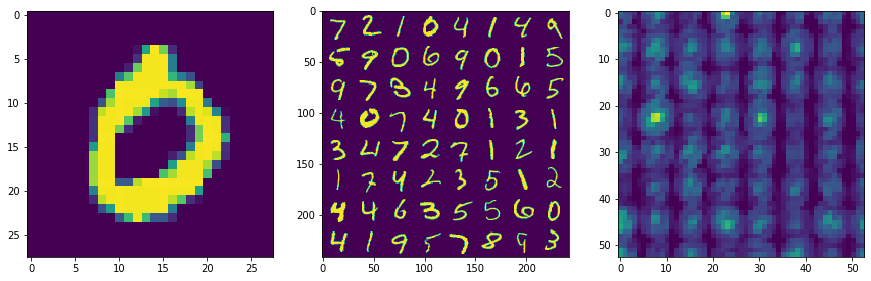

In [ ]:
pool = torch.nn.MaxPool2d(kernel_size=4)

ax[2].imshow(pool(conv_out).data.numpy()[0, 0])
fig

So, we will try a CNN similar in structure to [LeNet](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).
It consists of two parts: a convolutional feature extractor and a fully-connected classifier. 
![](https://github.com/adasegroup/ML2020_seminars/raw/master/seminar13/img/lenet.png)

In [ ]:
class CNNBased(torch.nn.Module):
    def __init__(self, input_image_size, number_of_classes):
        super().__init__()
        in_channels, height, width = input_image_size
        image_size = np.asarray([height, width])
        
        # convolutional feature extractor
        self.stage1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3),
            # -(kernel_size - 1) = -2 pixels in each dimension
            torch.nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2))
            # half the pixels in each dimension
            
        assert np.all(image_size % 2 == 0)
        image_size = (image_size - 4) // 2
        
        self.stage2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2))
        
        assert np.all(image_size % 2 == 0)
        image_size = (image_size - 4) // 2
        
        # fully-connected classifier
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(np.prod(image_size) * 16, 20),
            torch.nn.ReLU(),
            torch.nn.Linear(20, number_of_classes))
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        x = self.stage1(x)
        x = self.stage2(x)
        x = x.reshape(batch_size, -1)
        x = self.fc(x)
        return x

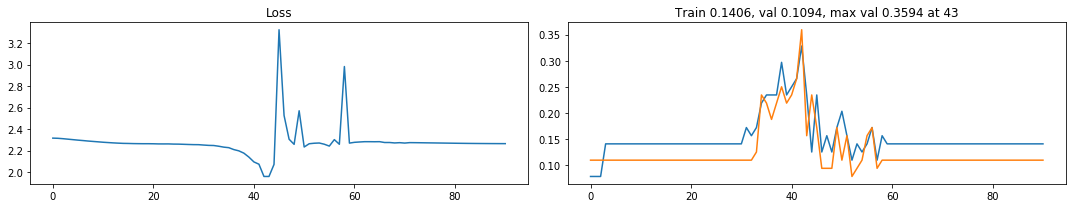

100%|██████████| 100/100 [00:41<00:00,  2.52it/s]


In [ ]:
set_random_seeds(device=device)

model = CNNBased([1, 28, 28], 10)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)

train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=100, plot_each=10)

The gradints most likely exploded and the neural network died.
Let's try Batch normalization layer to counter this.

## 5. Use BatchNorm
Batch normalization, as the name implies, normalizes the input in the batch dimension.
In our case it's most likely going to help, since it stablizes training (see this [explanation by Ian Goodfellow](https://youtu.be/Xogn6veSyxA) on how Batch normalization helps training NNs).

We add `BatchNorm2d` after each convolutional layer and `BatchNorm1d` after the first linear layer.

In [ ]:
class CNNBN(torch.nn.Module):
    def __init__(self, input_image_size, number_of_classes):
        super().__init__()
        in_channels, height, width = input_image_size
        image_size = np.asarray([height, width])
        
        self.stage1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3),
            torch.nn.BatchNorm2d(8),  ## <---
            torch.nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3),
            torch.nn.BatchNorm2d(8),  ## <---
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2))
            
        assert np.all(image_size % 2 == 0)
        image_size = (image_size - 4) // 2
        
        self.stage2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            torch.nn.BatchNorm2d(16),  ## <---
            torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            torch.nn.BatchNorm2d(16),  ## <---
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2))
        
        assert np.all(image_size % 2 == 0)
        image_size = (image_size - 4) // 2
        
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(np.prod(image_size) * 16, 20),
            torch.nn.BatchNorm1d(20),  ## <---
            torch.nn.ReLU(),
            torch.nn.Linear(20, number_of_classes))
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        x = self.stage1(x)
        x = self.stage2(x)
        x = x.reshape(batch_size, -1)
        x = self.fc(x)
        return x

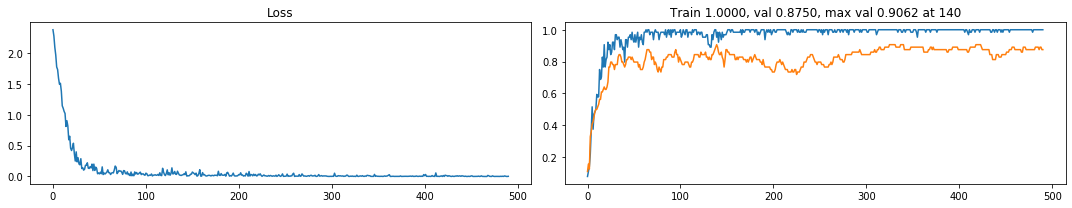

100%|██████████| 500/500 [03:29<00:00,  2.50it/s]


In [ ]:
set_random_seeds(device=device)

model = CNNBN([1, 28, 28], 10)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)

train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=500, plot_each=10)

So, we got a decent result taking into account that our training dataset consists of only 64 samples.
Let's see what else we can do.

We see that while the loss and train accuracy are relatively stable starting from 150 iterations, validation accuracy jumps quite a lot.
This may indicate a too high learning rate.
Let's try reducing it, but in a clever way.

## 6. Schedule your LR
It would be ideal to make several epochs with a large learning rate to quickly reach the optimum neighborhood,
and only then continue with a small learning rate to get to the optimum more accurately.
PyTorch provides `torch.optim.lr_scheduler` for this.

We modify our training procedure to take scheduler and do `scheduler.step()` at the end of each epoch.

In [ ]:
def train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=1, plot_each=1, scheduler=None):
    model = model.to(device)
    monitor = Monitor()
    for epoch in trange(epochs_n):
        model.train()
        for model_input, target in train_loader:
            model_input = model_input.to(device)
            target = target.to(device)
            model_output = model(model_input)
            loss = loss_function(model_output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            monitor.add_loss_value(loss.item())
        
        model.eval()
        train_accuracy = get_accuracy(model, train_loader, device)
        val_accuracy = get_accuracy(model, val_loader, device)
        monitor.add_train_accuracy_value(train_accuracy)
        monitor.add_val_accuracy_value(val_accuracy)
        
        if epoch % plot_each == 0:
            monitor.show()
            
        if scheduler is not None:  ## <---
            scheduler.step()       ## <---

Let's try training with learning rate `1e-1` for first `150` epochs,
and then decrease the learning rate by the factor of `10`.
For this, we'll use `torch.optim.lr_scheduler.MultiStepLR`:
we pass it the optimzer, set the `milestones` at which we want the learning rate to change,
and the factor `gamma` by which we want to change it.

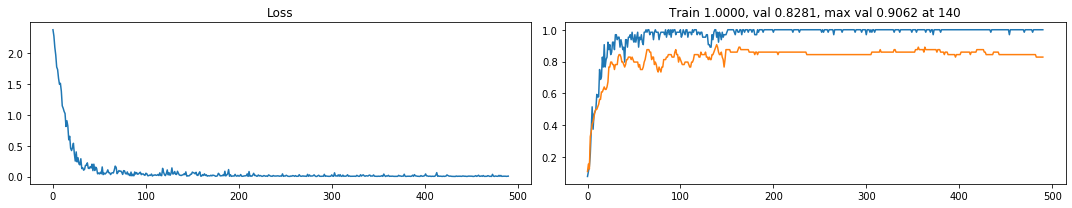

100%|██████████| 500/500 [03:31<00:00,  2.41it/s]


In [ ]:
set_random_seeds(device=device)

model = CNNBN([1, 28, 28], 10)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=(150, ), gamma=.1)

train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=500, plot_each=10, scheduler=scheduler)

LR scheduling helped to get rid of large jumps in validation accuracy but did not improve the maximum validation accuracy.

## 7. Try a different optimizer

Another thing we could do is try different optimizer.
There is [a lot of them](https://ruder.io/optimizing-gradient-descent/), we'll try Adam.
It adaptively scales the learning rate during the training, and usually gives a decent performance with default parameters.

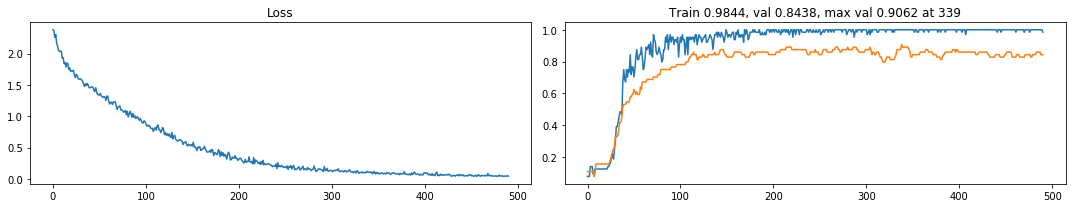

100%|██████████| 500/500 [03:32<00:00,  2.44it/s]


In [ ]:
set_random_seeds(device=device)

model = CNNBN([1, 28, 28], 10)
optimizer = torch.optim.Adam(model.parameters())

train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=500, plot_each=10)

We get the same top performance, but keep in mind that with proper selection of hyperparameters, such as learning rate, SGD gives better performance.

## 8. Dropout?

We're not done yet, since our model still overfits, i.e the train accuracy reaches the maximal value and the val accuracy doesn't.
Another regularization technique we can use is called Dropout.
Basically, at each iteration of training we randomly break the connection between neurons.
![](https://github.com/adasegroup/ML2020_seminars/raw/master/seminar13/img/dropout.png)


Since there's evidence that Dropout may actually decrease the performance of the network when used with Batch normalization (see e.g [this paper](https://arxiv.org/abs/1801.05134)), we will be carefull and will only add one Dropout layer after all Batch normalization layers in our network.

In [ ]:
class CNNBNDropout(torch.nn.Module):
    def __init__(self, input_image_size, number_of_classes):
        super().__init__()
        in_channels, height, width = input_image_size
        image_size = np.asarray([height, width])
        
        self.stage1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=3),
            torch.nn.BatchNorm2d(8),
            torch.nn.Conv2d(in_channels=8, out_channels=8, kernel_size=3),
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2))
            
        assert np.all(image_size % 2 == 0)
        image_size = (image_size - 4) // 2
        
        self.stage2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            torch.nn.BatchNorm2d(16),
            torch.nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2))
        
        assert np.all(image_size % 2 == 0)
        image_size = (image_size - 4) // 2
        
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(np.prod(image_size) * 16, 20),
            torch.nn.BatchNorm1d(20),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=.8),  ## <---
            torch.nn.Linear(20, number_of_classes))
        
    def forward(self, x):
        batch_size = x.shape[0]
        
        x = self.stage1(x)
        x = self.stage2(x)
        x = x.reshape(batch_size, -1)
        x = self.fc(x)
        return x

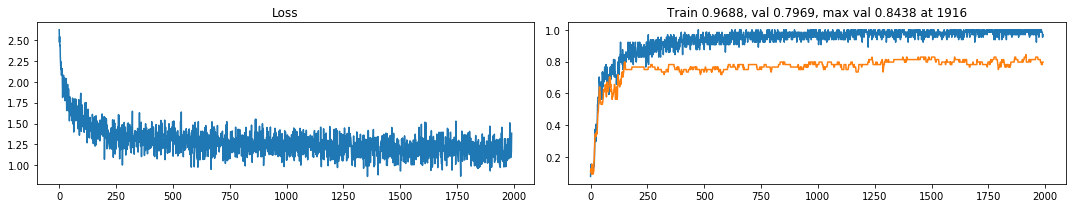

100%|██████████| 2000/2000 [14:24<00:00,  2.41it/s]


In [ ]:
set_random_seeds(device=device)

model = CNNBNDropout([1, 28, 28], 10)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=(150, ), gamma=.1)

train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=2000, plot_each=10, scheduler=scheduler)

So we actually got worse performance.
Still, let's see how this model performs on the whole validation dataset.

In [ ]:
val_loader = torch.utils.data.DataLoader(mnist_val, batch_size=batch_size, num_workers=4)
model.eval()
get_accuracy(model, val_loader, device)

0.776

Not bad, taking into account that the model trained on only 64 samples.

## 9. Recap on CIFAR
### Exercise 2
Now try all these techniques for CIFAR.
Your goal is to get the best performance on validation set (while using only the train data for training of course).
Don't forget to use `set_random_seeds(device=device)` before each initialization of the model to get reproducible results. 

Start on a subset and see how different techniques help.
What else you could do to further improve the performance:
* use standart ML techniques such as cross-validation, ensembling, etc --- surely will help, but don't use it here
* [`Normalize`](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.Normalize) the input --- may help, but may instead degrade the performance
* shuffle the training data using the `shuffle` parameter of `DataLoader`
* add $L_2$ regularization, aka weight decay, using the corresponding parameter of the optimizer or [`clamp`](https://pytorch.org/docs/stable/torch.html#torch.clamp) the weights directly --- unlikely will help since we already use BatchNorm (see e.g [this work](https://arxiv.org/abs/1706.05350))
* schedule learning rate more accurately --- most likely will help
* and, of course, STACK MORE LAYERS.

In [ ]:
cifar_train = torchvision.datasets.CIFAR10('./cifar', train=True, download=True,
                                           transform=torchvision.transforms.ToTensor())
cifar_val = torchvision.datasets.CIFAR10('./cifar', train=False, download=True,
                                         transform=torchvision.transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified


First, we select a data subset to debug our model on

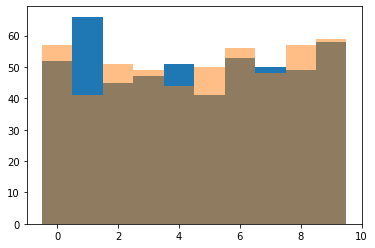

In [ ]:
subset_size = 512
cifar_train_subset = torch.utils.data.Subset(cifar_train, torch.arange(subset_size))
cifar_val_subset = torch.utils.data.Subset(cifar_val, torch.arange(subset_size))
plt.hist([target for _, target in cifar_train_subset], bins=10, range=(-.5, 9.5));
plt.hist([target for _, target in cifar_val_subset], bins=10, range=(-.5, 9.5), alpha=.5);

First of all, we see that the performance is quite low for an MLP-based model

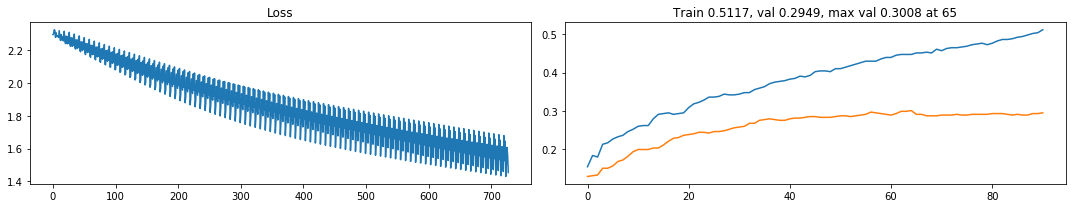

100%|██████████| 100/100 [00:46<00:00,  2.23it/s]


In [ ]:
set_random_seeds(device=device)

batch_size = 64
train_loader = torch.utils.data.DataLoader(cifar_train_subset, batch_size=batch_size, num_workers=4)
val_loader = torch.utils.data.DataLoader(cifar_val_subset, batch_size=batch_size, num_workers=4)

model = MLPBased([3, 32, 32], 100, 10)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=100, plot_each=10)

We may try increasing the learning rate

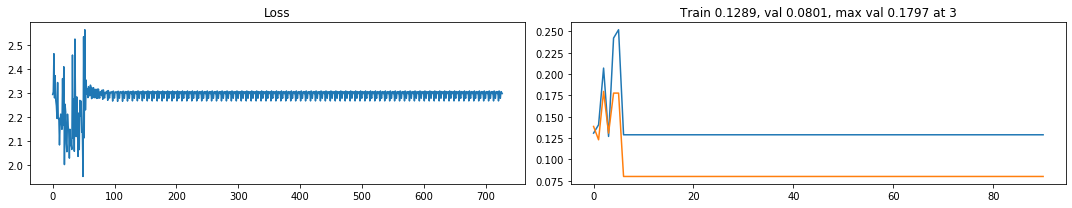

100%|██████████| 100/100 [00:46<00:00,  2.31it/s]


In [ ]:
set_random_seeds(device=device)

model = MLPBased([3, 32, 32], 100, 10)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, momentum=0.9)

train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=100, plot_each=10)

Or try a different optimizer right away

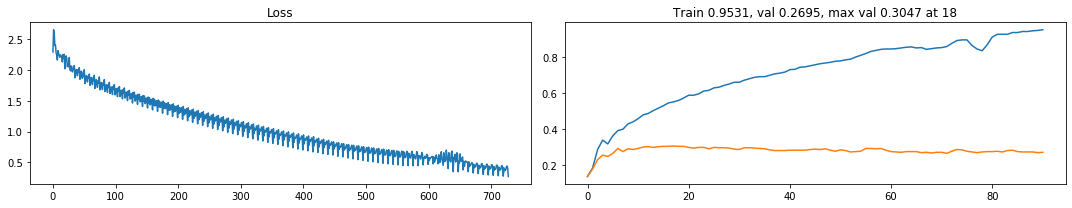

100%|██████████| 100/100 [00:46<00:00,  2.24it/s]


In [ ]:
set_random_seeds(device=device)

model = MLPBased([3, 32, 32], 100, 10)
optimizer = torch.optim.Adam(model.parameters())

train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=100, plot_each=10)

Adam gives a nice performance, but the model overfits. Let's augment, but first, let's look at the input images.

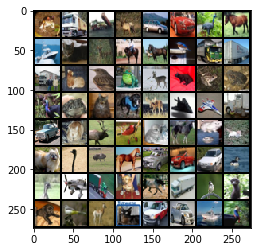

In [ ]:
for x, _ in train_loader:
    imgrid = torchvision.utils.make_grid(x, nrow=8)
    plt.imshow(imgrid.numpy().transpose(1,2,0))
    break

Let's try scaling and rotation as with MNIST, but remove shearing and add slight translation and horizontal flipping.

In [ ]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomAffine(degrees=15, scale=(.7, 1.05), translate=(.1, .1)),
    torchvision.transforms.RandomHorizontalFlip(p=0.5),
    torchvision.transforms.ToTensor()])


cifar_train_subset = torch.utils.data.Subset(
    torchvision.datasets.CIFAR10('./cifar', train=True, transform=transform), torch.arange(subset_size))

train_loader = torch.utils.data.DataLoader(cifar_train_subset, batch_size=batch_size, num_workers=4)

Let's ensure that we didn't augment too much.

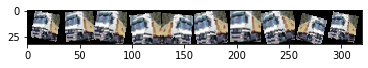

In [ ]:
augmentations = []
for _ in range(10):
    x, _ = cifar_train_subset[1]
    augmentations.append(x.permute(1,2,0))
    
plt.imshow(np.hstack(augmentations))

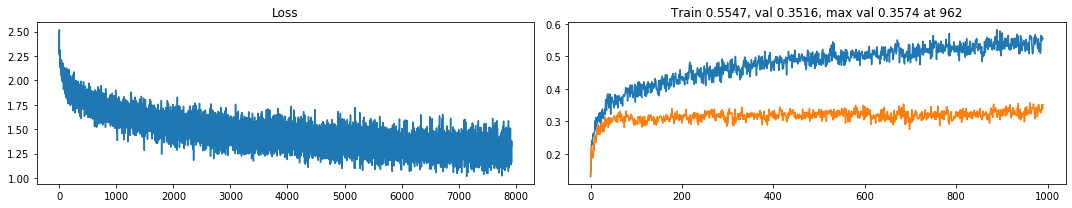

100%|██████████| 1000/1000 [08:06<00:00,  2.06it/s]


In [ ]:
set_random_seeds(device=device)

model = MLPBased([3, 32, 32], 100, 10)
optimizer = torch.optim.Adam(model.parameters())

train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=1000, plot_each=10)

Now, the performance is rather low, so let's try CNN, with batch normalization right away, at first without dropout.

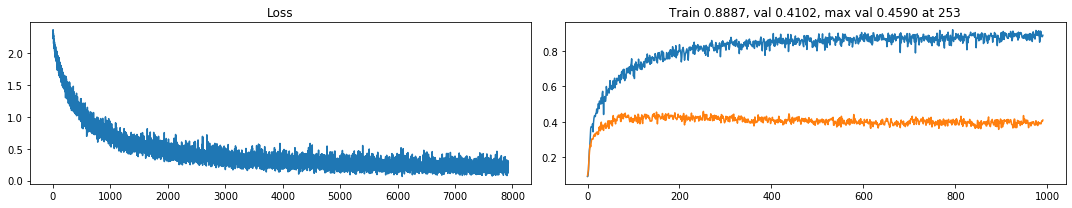

100%|██████████| 1000/1000 [08:34<00:00,  2.03it/s]


In [ ]:
set_random_seeds(device=device)

model = CNNBN([3, 32, 32], 10)
optimizer = torch.optim.Adam(model.parameters())

train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=1000, plot_each=10)

Better performance on train data but still quite bad performance on validation.

We may try more regularization techniques, like dropout, but at this moment it seems that we simply need more training data, since validation performance stops way before the train performance reaches it's peak.

Let's see how this setup performs when trained and validated on the whole dataset.

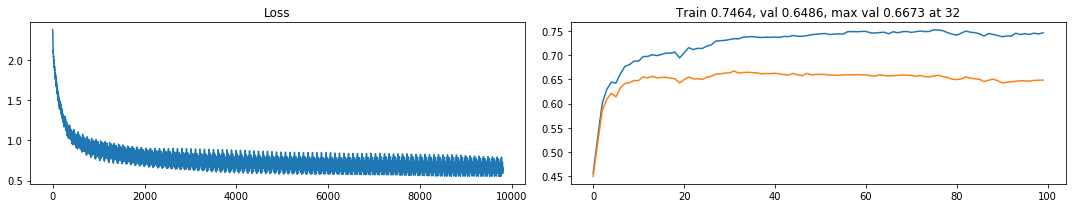

100%|██████████| 100/100 [05:17<00:00,  3.16s/it]


In [ ]:
batch_size = 512
train_loader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_size, num_workers=4)
val_loader = torch.utils.data.DataLoader(cifar_val, batch_size=batch_size, num_workers=4)

set_random_seeds(device=device)

model = CNNBN([3, 32, 32], 10)
optimizer = torch.optim.Adam(model.parameters())

train(model, optimizer, loss_function, train_loader, val_loader, device, epochs_n=100)